In [1]:
import pandas as pd
from pandas_datareader import data, wb
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats, integrate

import cvxpy as cp

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

(CVXPY) Apr 22 06:22:03 PM: Encountered unexpected exception importing solver ECOS:
ImportError('numpy.core.multiarray failed to import')


RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

(CVXPY) Apr 22 06:22:03 PM: Encountered unexpected exception importing solver ECOS_BB:
ImportError('numpy.core.multiarray failed to import')


In [2]:
import numpy as np

In [3]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [4]:
def import_data(tickers, start, end, give = "R", adj_close = True, dividend = True):#read in stock data  
    """
    tickers: tickers to read 
    start, end: dates in datetime.datetime(2015,12,1) format
    give: return prices or returns 
    adj_close: use adjusted or unadjusted price
    dividend: include dividend?
    """
    
    if give=='D':
        adj_close=False
        dividend = True
    
    stocks = pd.DataFrame()
    if (adj_close == True):
        dividend = False
        stocks[tickers] = data.DataReader(tickers, 'yahoo', start, end)['Adj Close']
    else:
        stocks[tickers] = data.DataReader(tickers, 'yahoo', start, end)['Close']
            
        if (dividend == True): 
            stock_div = pd.DataFrame(index=stocks.index)
            for tick in tickers:
                stock_div[tick+' div'] = data.DataReader(tick, 'yahoo-dividends', start, end)["value"]
      
    just_stocks=stocks
    if (dividend == True):
        stocks = pd.concat([stocks,stock_div],axis=1)
        stocks = stocks.fillna(0)
        
    if(give == "R"):
        #Adding dividends to price appreciation on a daily percent return basis -useful for all analysis
        raw_returns=pd.DataFrame()
        for tick in tickers:
            if (dividend == True):
                raw_returns[tick] = stocks[tick].pct_change() + stocks[tick+' div']/stocks[tick] 
                #dividends are actually added on the day before they should be added but this error is neglegible
            else:
                raw_returns[tick] = stocks[tick].pct_change()
        returns=raw_returns[1:]
        return returns[np.isfinite(returns).all(1)]
        
    if(give == "P"):
        return just_stocks
    
    if(give=="D"):
        dividend = pd.DataFrame(np.array(stocks.iloc[:,len(just_stocks.columns):])/np.array(stocks.iloc[:,:len(just_stocks.columns)])).set_index(just_stocks.index)
        dividend.columns=just_stocks.columns
        return dividend

In [9]:
start = datetime(2007,1,1)
end = datetime(2015,6,19)#when XLRE,XLC was introduced
tickers = ['XLV','XLI','XLB','XLK','XLU','XLY','XLP','XLF','XLE','SHY'] #.         #XLRE, XLC
sectordata = import_data(tickers, start, end).resample("W").apply(lambda x: ((x + 1).cumprod()-1).last("D")) 

In [24]:
sectordata.head()

,XLV,XLI,XLB,XLK,XLU,XLY,XLP,XLF,XLE,SHY
Date,,,,,,,,,,
2007-01-07,0.005672,-0.007664,-0.011268,0.007287,-0.019283,-0.007009,-0.005706,-0.011105,-0.011665,0.000376
2007-01-14,0.017513,0.017735,0.029515,0.022127,-0.006646,0.026405,0.014154,0.013421,-0.008584,-0.001874
2007-01-21,0.011377,0.001124,0.015328,-0.026644,0.005018,0.008915,0.003772,-0.001081,0.020563,0.000876
2007-01-28,-0.012691,-0.011510,0.008667,-0.001283,0.005548,-0.019692,-0.004510,-0.003788,0.004772,-0.000251
2007-02-04,0.014607,0.027833,0.015244,0.017130,0.023449,0.022663,0.011703,0.015481,0.031311,0.001753


In [11]:
#sectordata['SHY'] = sectordata['SHY']+.01

<AxesSubplot:xlabel='Date'>

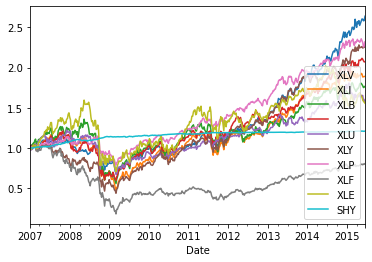

In [12]:
(sectordata+1).cumprod().plot()

In [13]:
def calculate_posterior_mean(like_pop, prior_pop):
    mu0 = prior_pop.mean()
    w0 = prior_pop.std()
    dbar = like_pop.mean()
    w = like_pop.std()
    # Prior:
    prior = stats.norm(mu0, w0)
    # Likelihood:
    like = stats.norm(dbar, w)
    #computer posterior mean, std, distribution
    B = w**2/(w**2+w0**2)
    mu_s =dbar+B*(mu0-dbar)
    w_s = w*np.sqrt(1-B)
    posterior = stats.norm(mu_s, w_s)
    return mu_s

#calculated expected return array
def likelihood_n_posterior_mus(n, data, period=16): #period of 16 is 3 months with weekly data
    like_mus = np.zeros(len(data.columns))
    post_mus = np.zeros(len(data.columns))
    for ints,sector in enumerate(data
                                 .columns): 
        likelihood_pop = np.array(data.iloc[n-period : n - 1][sector])
        prior_pop = np.array(data.iloc[n-period : n - 1])
        like_mus[ints] = likelihood_pop.mean() #normal mean opt 
        post_mus[ints] = calculate_posterior_mean(likelihood_pop,prior_pop) #bayesian means 
    return like_mus, post_mus

In [14]:
def max_sharpe(mu,cov):
    # Minimize portfolio Sharpe for given return (ret)
    z = cp.Variable(len(mu),) #transformed variable
    k = cp.Variable() #scalar (variable)
    ret = z.T @ mu
    sigma_square = cp.quad_form(z, cov)
    objective = cp.Minimize (sigma_square)
    constraints = [
                    ret == 1, #adjustable return target constraint
                    cp.sum(z) == k,
                    z >= 0,
                    k >= 0
                    ]
    prob = cp.Problem(objective, constraints)
    prob.solve(verbose = False)
    return (z.value / k.value)

def weighted_stuff(n, dat):
    dat = np.array(dat)
    alpha = 0.5
    weights = np.flip((1-alpha)**np.arange(0,len(dat),1))
    weights = weights/np.sum(weights) # normalize
    weighted = dat.T*weights
    w_means = np.sum(weighted,axis=1)                             # weighted means
    w_covs = dat.T@np.diag(weights)@dat-np.outer(w_means,w_means) # weighted covs
    return w_covs #w_means, 

def tangent_rebalance(stocks, n, formation_period, port, weights, total, expt_rtn = 'like', Lower_bound=0, Upper_bound=1,annualizer = 52, muf = 0, wcov = False, pyopt_weights = False):
    likeMu, postMu = likelihood_n_posterior_mus(n, period=formation_period, data = stocks)
    if wcov == False:
        cov = stocks[n-formation_period : n - 1].cov()
    if wcov == True:
        cov = weighted_stuff(n, stocks[n-formation_period : n - 1]) #weighted cov
    if expt_rtn == 'like':
        tangent_weights = max_sharpe(likeMu,cov)
        ef = EfficientFrontier(likeMu, cov)
    elif expt_rtn == 'not like':
        tangent_weights = max_sharpe(postMu,cov)
        ef = EfficientFrontier(postMu, cov)

    #print("pyopt weights", ef.max_sharpe())
    if pyopt_weights==False:
        return tangent_weights
    if pyopt_weights == True:
        return np.array(list(ef.max_sharpe().values()))

In [15]:
def backtest(weights, col, dataf, expt_rtns = 'like', wcov = False, days_between_rebalance=1, show_weights=False, wealth = 1, RebalanceOffset=0,formation = 0, pyopt = False): #cols allows users to backtest subsets of dataframe
    """
    weights: tells the function the number of assets. sets the starting weights and is the weights for constant rebalancing
    wealth: sets starting value
    RebalanceOffset: to offset day of rebalances by these values to provide information about rebalance timing luck
    give: return returns or prices
    formation: number of days covariance matrix is formed over
    
    """
    colin=[0]*len(weights)
    port=[0]*len(weights)
    worth=[wealth]

    for n in range(len(weights)):
        colin[n] = dataf.columns.get_loc(col[n])
        port[n]=wealth*weights[n]

    for n in range (formation,len(dataf)):
        
        return_vector = np.array((1+dataf.iloc[n,colin]))
        
        #print("port weights", port)
        #print("value", sum(port))
        #print("asset returns",return_vector)
        
        port = np.multiply(port, return_vector)

        #print("new_port",np.round(port,3))
        #print("value", sum(port))
        end_of_day = sum(port)
        worth.append(end_of_day)
        
        if ((n + RebalanceOffset)% days_between_rebalance==0):        #rebalance
            port=tangent_rebalance(dataf, n, formation, port, weights, total = sum(port), expt_rtn = expt_rtns, wcov = wcov, pyopt_weights = pyopt)*end_of_day
            if show_weights == True:
                print(np.round(np.array(port/sum(port)),2))
        
                           
    return pd.DataFrame(worth).pct_change()[1:].set_index(dataf.index[formation:])

In [21]:
initial_weights = np.ones(len(sectordata.columns))/len(sectordata.columns)

#standard covariance 5 yr lookback for expted returns and covariance
likelihood = backtest(initial_weights, sectordata.columns, sectordata, formation = 63, expt_rtns = 'like')
posterior = backtest(initial_weights, sectordata.columns, sectordata, formation = 63, expt_rtns = 'not like')

In [22]:
comparisons = pd.concat([likelihood.rename({0:'like'},axis=1),posterior.rename({0:'post'},axis=1)], axis=1)

<AxesSubplot:xlabel='Date'>

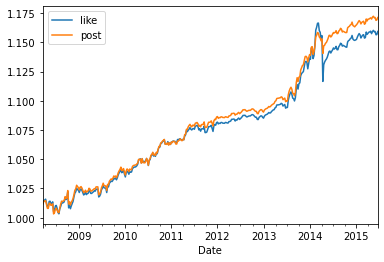

In [23]:
((comparisons+1).cumprod()).plot()

In [47]:
mu = expected_returns.mean_historical_return(sectordata, returns_data=True,frequency=12)
S = risk_models.sample_cov(sectordata, returns_data=True,frequency=12)

In [49]:
# Calculate expected returns and sample covariance


# Optimize for maximal Sharpe ratio


mu = expected_returns.mean_historical_return(sectordata, returns_data=True,frequency=12)
S = risk_models.sample_cov(sectordata, returns_data=True,frequency=12)
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
ef.portfolio_performance(verbose=True)

Expected annual return: 4.1%
Annual volatility: 2.4%
Sharpe Ratio: 0.84


(0.04054834458401306, 0.024337359784864832, 0.8443128081950728)

In [ ]:
experiments, shrinkage for expected returns     #, shrinkage of cov, exponential weighting for both